# Part 3: Temporal-Difference (TD) Learning

In this seminar, we will implement and evaluate time-differencing (TD) methods. 
Specifically, we will consider examples in which we use the following solution methods:

* A. The Random Walk problem: value function estimation using TD(0) methods
* B. The Windy GridWorld problem: SARSA algorithm for estimation of the action value function and control 

The learning methods considered are based on backups which for dynamic programming, Monte Carlo, and temporal-difference learning can be represented as follows:

<table><tr>
<td> <img src="./graphs/dp.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./graphs/mc.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./graphs/td.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

### The environment 

<img src="./graphs/randomwalk.png" width="800"/>

Reward is 1 if we move from E to S and 0 otherwise.

We first define the environment. 

Following the style of OpenAI Gym, we write a class that contains a step function and a reset function:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
# actions
left = 0
right = 1

class RandomWalk:
    def __init__(self, initial_state):
        self.initial_state = initial_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        if self.state == 5 and action == right:
            self.state += 1
            self.is_terminal = True
            self.reward = 1.0
        elif self.state == 1 and action == left:
            self.state -= 1
            self.is_terminal = True
            self.reward = 0.0
        else:
            if action == left:
                self.state -= 1
                self.is_terminal = False
                self.reward = 0.0

            else:
                self.state += 1
                self.is_terminal = False
                self.reward = 0.0

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

### Random policy 
A policy that takes a random action (0, 1):

In [3]:
def random_policy():
    return np.random.binomial(1, 0.5)

### The learning algorithm

Our goal is to estimate the value function using the TD(0) algorithm, which was described in the lecture notes:

<img src="./graphs/td_algo.png" width="800" height="450">

Implement the TD algorithm with step size = 0.1 and no discount:

In [4]:
def temporal_difference(value, next_value, r, alpha=0.1):
    return value + alpha * (r + next_value - value)

In [5]:
def plot_state_value(history, true_values):
    plt.figure(1)
    x = [1, 2, 3, 4, 5]
    my_xticks = ['A', 'B', 'C', 'D', 'E']
    plt.xticks(x, my_xticks)
    episodes = [0, 1, 10, 100]
    for i in range(len(history)):
        if i in episodes:
            plt.plot(x, history[i][1:6], 'o-', label=str(i)+' episode(s)')
    plt.plot(x, true_values[1:6], label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()
    plt.show()
    
true_values = np.zeros(7)  
true_values[1:6] = np.arange(1, 6) / 6.0  
true_values[6] = 0.  

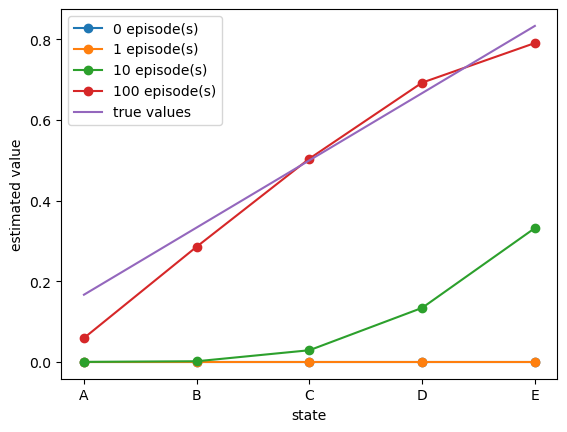

In [6]:
values = np.zeros(7)  
value_history = [np.copy(values)]  
  
initial_state = 3  
env = RandomWalk(initial_state)
  
episodes = 100  
  
for i in range(1, episodes + 1):  
    state = env.reset()  
    done = False  
  
    while not done:  
        a = random_policy()  
        next_state, r, done = env.step(a)  
        values[state] = temporal_difference(values[state], values[next_state], r)  
        state = next_state  
  
    value_history.append(np.copy(values))  
plot_state_value(value_history, true_values)

## B. The Windy GridWorld problem

The goal of this exercise is implement and evaluate SARSA algorithm for the Windy GridWorld problem which is defined as follows.

The Windy GridWorld problem is described in **Example 6.5** in Sutton & Barto. 
![alt text](./graphs/windy_grid.png)

The Windy Gridworld problem is a standard gridworld with a crosswind upward through the middle of the grid. The strength of the wind is indicated by the number below each column.  For example, if you are in the cell to the right of the goal, the action left will take you to the cell above the goal.  To be precise, the next cell you will end up in depends on the action taken and the wind in the current cell. 
- An undiscounted episodic task
- Rewards of -1 until the goal is reached

Similarly, define the variables and parameters as defined in the book,

In [7]:
world_height = 7
world_width = 10
wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

### The environment
A step function that returns next state, reward and is_done.  **Note** that the next state is the current state moved towards the current action direction + the wind direction of the **current** state.

In [8]:
class WindyGridworld:
    def __init__(self, init_position, goal_position):
        self.initial_state = init_position
        self.goal_state = goal_position
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    # return (next state, reward, is_done)
    def step(self, action):
        i, j = self.state

        if self.state == self.goal_state:
            self.reward = 0.0
            self.is_terminal = True
        else:
            if action == up:
                self.state = [max(i - 1 - wind_strength[j], 0), j]
            elif action == left:
                # the next state (j-1) is the action + the wind in the previous state (j)
                self.state = [max(i - wind_strength[j], 0), max(j - 1, 0)]
            elif action == right:
                self.state = [max(i - wind_strength[j], 0), min(j + 1, world_width - 1)]
            elif action == down:
                self.state = [max(min(i + 1 - wind_strength[j], world_height - 1), 0), j]
            else:
                assert False, "Actions should be in the range of (0, 4)."
            self.reward = -1.0
            self.is_terminal = False

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state



### The policy

Implement an $\varepsilon$-greedy policy

In [9]:
def epsilon_greedy_policy(q_values, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(q_values) if value_ == np.max(q_values)])

### The algorithm: 
<img src="./graphs/sarsa.png" width="750" height="100">

<img src="./graphs/sarsa_algo.png" width="800" height="450">

In [10]:
def sarsa(qsa, next_qsa, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * next_qsa - qsa)

Solve the Windy GridWorld problem:

In [11]:
q_sa = np.zeros((world_height, world_width, len(actions)))  
episodes = 200
timesteps = []  
  
start_position = [3, 0]  
terminal_position = [3, 7]  
  
env = WindyGridworld(start_position, terminal_position)  
  
for i in range(1, episodes + 1):  
    state = env.reset() 
    is_done = False
    row, col = state  
    # initialise a  
    a = epsilon_greedy_policy(q_sa[row, col, :])  
    timesteps_per_epi = 1  
  
    while not is_done:  
        next_state, r, is_done = env.step(a)  
        row, col = state  
        n_row, n_col = next_state  
        
        next_a = epsilon_greedy_policy(q_sa[n_row, n_col, :])  
        q_sa[row, col, a] = sarsa(q_sa[row, col, a], q_sa[n_row, n_col, next_a], r)  
  
        state = next_state  
        a = next_a  
        timesteps_per_epi += 1  
    timesteps.append(timesteps_per_epi)

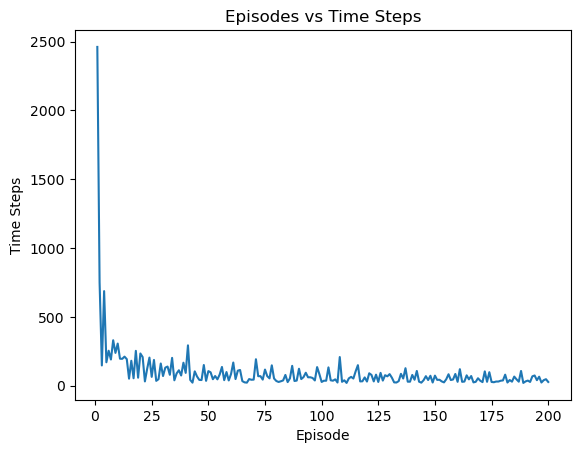

In [12]:
def plot_episode_steps(steps, episodes):
    plt.plot(np.arange(1, episodes + 1), steps)
    plt.title("Episodes vs Time Steps")
    plt.xlabel("Episode")
    plt.ylabel("Time Steps")
    plt.show()

plot_episode_steps(timesteps, episodes)

In this problem, the only way to terminate an episode is to reach the goal state. The curve shows that the number of time steps requires drastically decreases. 

**Note** that the policy is unable to converge to the optimal policy after 170 episodes. Let the number of episodes be 1000. 
By the end of 1000 episodes, we choose a greedy policy

In [13]:
def print_optimal_policy(policy, terminal_position):
    policy_display = np.empty_like(policy, dtype=str)
    wind = np.empty_like(wind_strength, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            wind[j] = str(wind_strength[j])
            if [i, j] == terminal_position:
                policy_display[i, j] = 'G'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print('Optimal policy is:')
    for row in policy_display:
        print(row)
    print(wind)
    
episodes = 1000
for i in range(1, episodes + 1):  
    state = env.reset() 
    is_done = False
    row, col = state  
    # initialise a  
    a = epsilon_greedy_policy(q_sa[row, col, :])  
  
    while not is_done:  
        next_state, r, is_done = env.step(a)  
        row, col = state  
        n_row, n_col = next_state  
        
        next_a = epsilon_greedy_policy(q_sa[n_row, n_col, :])  
        q_sa[row, col, a] = sarsa(q_sa[row, col, a], q_sa[n_row, n_col, next_a], r)  
  
        state = next_state  
        a = next_a  

optimal_policy = np.argmax(q_sa, axis=2)
print_optimal_policy(optimal_policy, terminal_position)

Optimal policy is:
['D' 'R' 'U' 'R' 'U' 'R' 'R' 'R' 'R' 'D']
['D' 'U' 'R' 'U' 'R' 'R' 'R' 'R' 'U' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'R' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'G' 'R' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'U' 'D' 'L' 'L']
['D' 'R' 'R' 'D' 'R' 'U' 'U' 'R' 'L' 'D']
['R' 'R' 'R' 'U' 'U' 'U' 'U' 'U' 'L' 'U']
['0' '0' '0' '1' '1' '1' '2' '2' '1' '0']
